In [1]:
using Revise
# Tensor_trains 
using TensorTrains, TensorCast, Tullio, LogarithmicNumbers, ProgressMeter, LinearAlgebra
using TensorTrains: compress, TruncBondThresh  

# MonteCarlo
using Random, Statistics, Distributions

# Graphics
using Plots, Colors

includet("tensor_builder.jl")
includet("calculo_observables.jl")
includet("monte_carlo_swap.jl")
includet("parallel_monte_carlo_Glauber.jl")

includet("efficient_observables.jl")

In [2]:
"""
    plot_two_sextuples(times, Sdots, Slines; site_labels=nothing, savepath=nothing)

Grafica dos series temporales de vectores por sitio:
- `times`: vector de tiempos (length T)
- `Sdots`: datos para graficar como puntos — forma N×T o T×N
- `Slines`: datos para graficar como líneas — forma N×T o T×N

Cada fila i corresponde al sitio i. Si la entrada viene en orientación time×sites,
la función la transpone automáticamente.

Opciones:
- `site_labels`: vector de etiquetas para leyenda (por defecto "Sitio 1", ...).
- `savepath`: si no es `nothing` guarda la figura en ese archivo (PNG, PDF, ...).
"""
function plot_two_Ntuples(times, Sdots, Slines; site_labels=nothing, titled="Marginal expectation per spin over steps", savepath=nothing)
    # Normalizar formatos: queremos N × T
    if size(Sdots,1) == length(times) && size(Sdots,2) != length(times)
        Sdots = permutedims(Sdots)   # T×N -> N×T
    end
    if size(Slines,1) == length(times) && size(Slines,2) != length(times)
        Slines = permutedims(Slines)
    end

    @assert size(Sdots) == size(Slines) "Sdots y Slines deben tener la misma forma"
    N, T = size(Sdots)
    @assert length(times) == T "length(times) debe coincidir con número de columnas en Sdots/Slines"

    # Etiquetas por sitio
    if site_labels === nothing
        site_labels = ["Sitio $i" for i in 1:N]
    else
        @assert length(site_labels) == N "site_labels debe tener longitud N"
    end

    cols = distinguishable_colors(N)  # paleta con N colores distinguibles

    p = plot(title=titled,
             xlabel="Tiempo", ylabel="Valor",
             legend=:outerright, grid=true, size=(900,500))

    # Dibujar: línea para Slines (con label) y puntos para Sdots (sin duplicar labels)
    for i in 1:N
        plot!(p, times, Slines[i, :],
              color=cols[i], linewidth=2, label=site_labels[i])
        scatter!(p, times, Sdots[i, :],
                 color=cols[i], marker=:circle, markersize=4, label=false)
    end

    if savepath !== nothing
        savefig(p, savepath)
    end

    return p
end

plot_two_Ntuples

## Pruebas

In [3]:
N = 11
t = 100
max_bound = 5

# TensotTrain de transición simpmle
A = build_transition_tensorchain(transition_rate, random_params(N))
# TensorTrain de probabilidad tiempo t simple
B_t = tensor_b_t(A, random_P0(N), t, max_bound)

# TensorTrain de transición paralela
A_plus = parallel_transition_tensor_train(transition_rate, parallel_random_params(N))

# TensorTrain de probabilidad tiempo t paralela con cadenas independientes
B_t_plus = tensor_b_t(A_plus, random_P0(N, 4), t, max_bound)

# TensorTrain de probabilidad tiempo t paralela con condiciones iniciales fijas
B_t_plus_fixed = tensor_b_t(A_plus, parallel_random_P0_fixed(N), t, max_bound)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:19
Progress: 100%|█████████████████████████████████████████| Time: 0:00:19
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


TensorTrain{Float64, 3, Array{Float64, 3}, LogFloat64}([[0.23098552693534938 0.23978316255558893 -0.23137371051883251 0.24018613103935715;;; 0.23137371053863728 0.24018613102027886 0.2309855269551988 -0.23978316253646775;;; 0.239783162533405 -0.23098552691281263 -0.2401861310615039 -0.23137371054133143;;; 0.24018613104242545 -0.2313737105611364 0.23978316251428397 0.230985526932662], [0.2456242607008908 -0.22587846593674069 … 0.224869375610996 -0.009998892630012371; -0.00951023917249311 0.009514217321053528 … -0.009471717668567688 -0.23993725625267326; 0.0005681225487929404 -0.0005224510428795439 … 0.0005591105544293826 -2.3240157237362248e-5; 2.1996936714763838e-5 -2.2006138277549983e-5 … 2.3550732978303297e-5 0.0005549619177311385;;; 0.2445270480469584 -0.2248694584391137 … -0.22587836084473834 -0.009954229092942222; -0.009467756580791025 0.009471716957483944 … 0.009514217106084997 -0.23886548067498692; -0.0005706717605158666 0.0005247953115836838 … 0.0005659768839292854 2.3120399011

In [4]:
println("Suma total de B_t: ", sum_one_check(B_t))
println("Suma total de B_t_plus: ", sum_one_check(B_t_plus))
println("Suma total de B_t_plus_fixed: ", sum_one_check(B_t_plus_fixed),"\n")
println("Distribución marginal en el sitio 10 de B_t: ", marginal_distribution(B_t, 10))
println("Distribución marginal en el sitio 10 de B_t_plus: ", marginal_distribution(B_t_plus, 10))
println("Distribución marginal en el sitio 10 de B_t_plus_fixed: ", marginal_distribution(B_t_plus_fixed, 10),"\n")
println("Valor esperado marginal en el sitio 10 de B_t: ", marginal_expected_value_simple(B_t, 10))
println("Valor esperado marginal en el sitio 10 de B_t_plus: ", marginal_expected_value_parallel(B_t_plus, 10))
println("Valor esperado marginal en el sitio 10 de B_t_plus_fixed: ", marginal_expected_value_parallel(B_t_plus_fixed, 10))

Suma total de B_t: 1.0000000000000016
Suma total de B_t_plus: 1.0000000000000004
Suma total de B_t_plus_fixed: 0.9999999999999973

Distribución marginal en el sitio 10 de B_t: 
Suma total de B_t_plus: 1.0000000000000004
Suma total de B_t_plus_fixed: 0.9999999999999973

Distribución marginal en el sitio 10 de B_t: [0.14801424720830264, 0.8519857527916989]
Distribución marginal en el sitio 10 de B_t_plus: [0.24040902580631485, 0.24131669764902167, 0.25864886979786345, 0.25962540674680074]
Distribución marginal en el sitio 10 de B_t_plus_fixed: [0.24040853643027107, 0.24131737683273982, 0.2586481466551479, 0.2596259400818387]

Valor esperado marginal en el sitio 10 de B_t: 0.7039715055833962
Valor esperado marginal en el sitio 10 de B_t_plus: (0.0018842087916441375, 0.036548553089327696)
Valor esperado marginal en el sitio 10 de B_t_plus_fixed: (0.0018866338291595453, 0.03654817347397571)
[0.14801424720830264, 0.8519857527916989]
Distribución marginal en el sitio 10 de B_t_plus: [0.240409

## Parallel Dynamic

In [33]:
N = 20                                 # Número de espines
T = 100                               # Número de iteraciones (tiempo)
params = parallel_random_params(N)      # beta_1, beta_2, j_vector, h_vector, p0
P0 = parallel_random_P0_fixed(N)        # Configuración inicial aleatoria fija para X e Y

# MonteCarlo
P0_Monte_Carlo = [P0[k][4] for k in 1:N]
params_mc = GlauberParamsParallel( params.beta_1, params.beta_2, params.j_vector, params.h_vector, params.p0)
result_mc = run_parallel_monte_carlo(N, params_mc, P0_Monte_Carlo, T, N_samples = 10000, seed = 42)

mag_mc_time = compute_marginal_magnetization_parallel(result_mc)   # magnetización de cada espín por instante de tiempo

# TensorTrains
max_bound = 5

A_plus = parallel_transition_tensor_train(transition_rate, params)
B_t_plus_fixed = tensor_b_t_over_time(A_plus, P0, T, max_bound)

mag_tt_time = [marginal_ev_parallel_system(B_t_plus_fixed[k]) for k in 1:T]

print("done")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:58
Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


done

In [8]:
# params = (
#     N = 10,
#     beta_1 = 0.5,
#     beta_2 = 1.0,
#     j_vector = randn(N-1),
#     h_vector = randn(N),
#     p0 = 0.1
# )

In [9]:
print(params)

(N = 10, beta_1 = 0.29905872363063146, beta_2 = 0.9603971260704683, j_vector = [0.43243247858138956, -0.027876759117879235, 0.48298344247259295, 0.9828706069646576, -0.36565926969074614, -0.10582016731673427, -0.1368832542650218, -0.752919978918803, -0.06055824676119803], h_vector = [0.6831659975853652, -0.5227380208669941, 0.9373359393906762, -0.9244876882858384, 0.37336260522027587, 0.5173046272427975, 0.14275343614142022, -0.2563230017275073, 0.9266889943535546, -0.7695526559921573], p0 = 0.022382967411356258) = 10, beta_1 = 0.29905872363063146, beta_2 = 0.9603971260704683, j_vector = [0.43243247858138956, -0.027876759117879235, 0.48298344247259295, 0.9828706069646576, -0.36565926969074614, -0.10582016731673427, -0.1368832542650218, -0.752919978918803, -0.06055824676119803], h_vector = [0.6831659975853652, -0.5227380208669941, 0.9373359393906762, -0.9244876882858384, 0.37336260522027587, 0.5173046272427975, 0.14275343614142022, -0.2563230017275073, 0.9266889943535546, -0.76955265599

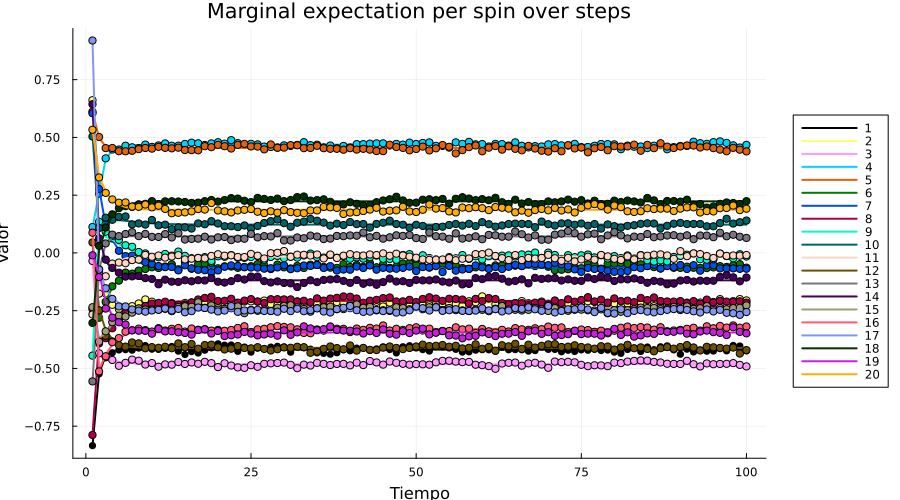

In [ ]:
numbers_of_spins = 20
lista_of_spins = sort(randperm(N)[1:numbers_of_spins])
str_lista = string.(lista_of_spins)

for system in 1:2
    Sdots = mag_mc_time[system][lista_of_spins, 1:T] # N x T

    Slines = zeros(size(Sdots))                        # N x T
    for k in 1:T
        for j in 1:length(lista_of_spins)
            spin_idx = lista_of_spins[j]
            Slines[j, k] = mag_tt_time[k][spin_idx][system]
        end
    end

    times = 1:T            # o el vector de tiempos que uses (length == size(spins_tt,2))
    p = plot_two_Ntuples(times, Sdots, Slines;
                           site_labels = str_lista,
                           savepath="sextuples_compare.png")
    display(p)
end

In [11]:
system_of_correlations = []
for t in 1:10
    push!(system_of_correlations, correlation_between_chains(B_t_plus_fixed[t]))
end

print(correlation_between_chains(B_t_plus_fixed[1]), "\n", covariance_between_chains(B_t_plus_fixed[1]), "\n")

[0.9999999999999996, 0.9999999999999998, 0.9999999999999998, 0.9999999999999998, 0.9999999999999999, 0.9999999999999999, 0.9999999999999997, 0.9999999999999998, 0.9999999999999998, 0.9999999999999996]
[0.7206087328822808, 0.9253528179030488, 0.9643855806238625, 0.9954909845843017, 0.8387346730585736, 0.9327765524171789, 0.7448207315218816, 0.9739454105499145, 0.918317284693085, 0.5566218583920182]


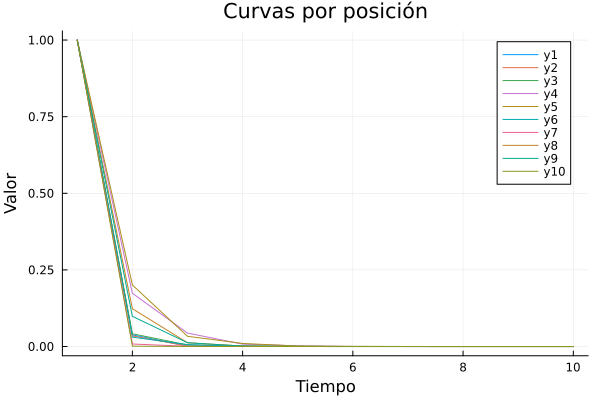

In [12]:
using Plots

# data: lista de T listas de N elementos
mat = hcat(system_of_correlations...)  # Convierte a matriz N x T
plot(mat' , legend=:topright, xlabel="Tiempo", ylabel="Valor", title="Curvas por posición")

### Some index references

    ( X  Y)

1-  (-1 -1)

2-  ( 1 -1)

3-  (-1  1)

4-  ( 1  1)

mag_tt_time[time][spin][X-Y]

mag_mc_time[X-Y][spin,time]

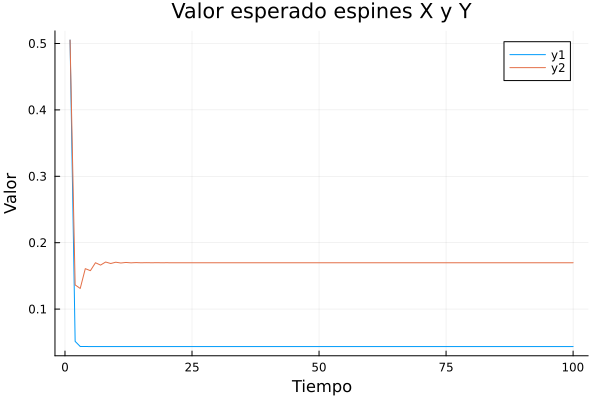

In [13]:
spin_X_ev_time = []
spin_Y_ev_time = []
spin_number = 7
for t in 1:100
    evs_X = mag_tt_time[t][spin_number][1]  # Valor esperado del espín X en el tiempo t
    evs_Y = mag_tt_time[t][spin_number][2]  # Valor esperado del espín Y en el tiempo t
    push!(spin_X_ev_time, evs_X)
    push!(spin_Y_ev_time, evs_Y)
end
mat_ev = hcat(spin_X_ev_time, spin_Y_ev_time)'  # Convierte a matriz 2 x T
plot(mat_ev', legend=:topright, xlabel="Tiempo", ylabel="Valor", title="Valor esperado espines X y Y")  

## Swap

In [15]:
N = 10                                 # Número de espines
# params = parallel_random_params(N)      # beta_1, beta_2, j_vector, h_vector, p0

# P0 = parallel_random_P0_fixed(N)        # Configuración inicial aleatoria fija para X e Y
P0 = P0 = [Float64[1.0, 0.0, 0.0, 0.0] for _ in 1:N]


10-element Vector{Vector{Float64}}:
 [1.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 0.0, 0.0]

In [16]:
T = 10                            # Número de iteraciones (tiempo)

params = (
    N = 10,
    beta_1 = 1.0,
    beta_2 = 10.0,
    j_vector = fill(1, N-1),
    h_vector = fill(0.01,N),
    p0 = 0.1
)
#  Número de iteraciones (tiempo)
# params = parallel_random_params(N)  

s = 0.05

# MonteCarlo
P0_Monte_Carlo = [P0[k][4] for k in 1:N]
params_mc = GlauberParamsParallelSwap( params.beta_1, params.beta_2, params.j_vector, params.h_vector, params.p0, s)
result_mc_swap = run_swap_parallel_monte_carlo(N, params_mc, P0_Monte_Carlo, T, N_samples = 10000, seed = 42)
observables_mc = compute_all_observables(result_mc_swap)


# TensorTrains
bond = 7

A_plus = parallel_transition_tensor_train(transition_rate, params)
B_t_swap = tensor_b_t_swap(A_plus, P0, T, bond, s, true)
B_t_parallel_fixed = tensor_b_t_over_time(A_plus, P0, T, bond)

system_of_observables_swap = system_description_over_time(B_t_swap, params)
system_of_observables_parallel = system_description_over_time(B_t_parallel_fixed, params)



print("done")



Progress: 100%|█████████████████████████████████████████| Time: 0:00:25
Progress: 100%|█████████████████████████████████████████| Time: 0:00:25
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


done

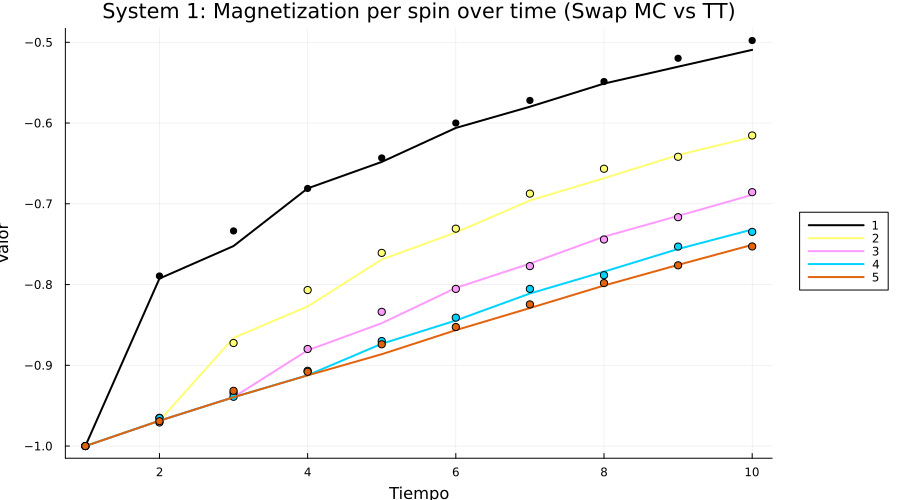

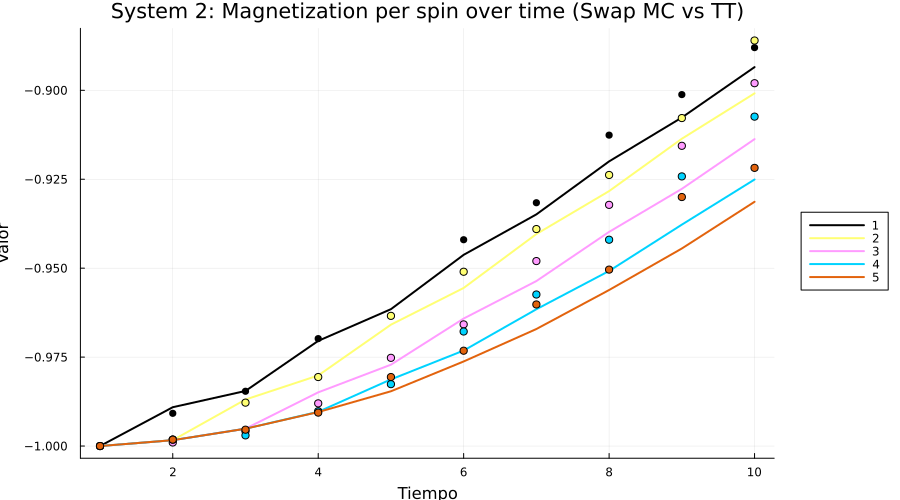

In [17]:
# Gráfica de resultados MonteCarlo vs TT magnteización por espin de cada cadena

mag_tt_time_swap = system_of_observables_swap.full_expected_values_t
mag_mc_time_swap = [observables_mc["magnetization_x"], observables_mc["magnetization_y"]]  # magnetización de cada espín por instante de tiempo

numbers_of_spins = 5
lista_of_spins = sort(randperm(N)[1:numbers_of_spins])
str_lista = string.(lista_of_spins)

T=10
for system in 1:2
    Sdots = mag_mc_time_swap[system][lista_of_spins, 1:T] # N x T

    Slines = zeros(size(Sdots))                        # N x T
    for k in 1:T
        for j in 1:length(lista_of_spins)
            spin_idx = lista_of_spins[j]
            Slines[j, k] = mag_tt_time_swap[k][spin_idx][system]
        end
    end

    times = 1:T            # o el vector de tiempos que uses (length == size(spins_tt,2))
    p = plot_two_Ntuples(times, Sdots, Slines;
                           site_labels = str_lista, titled = "System $system: Magnetization per spin over time (Swap MC vs TT)",
                           savepath="sextuples_compare.png")
    display(p)
end

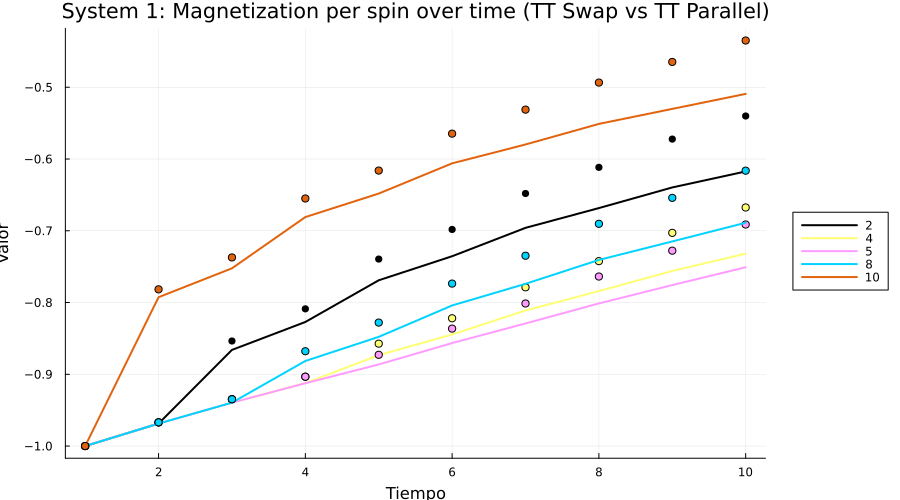

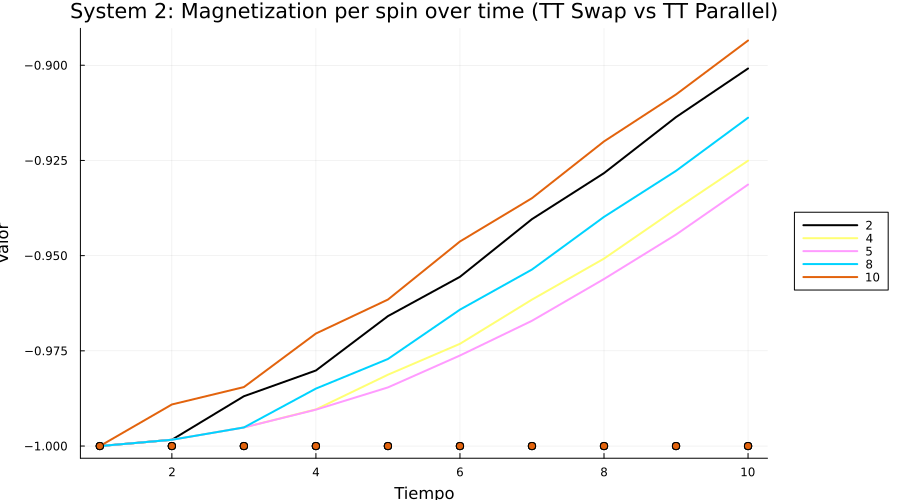

In [18]:
# Gráfica de resultados TT Swap vs TT Parallel magnteización por espin de cada cadena

mag_tt_time_swap = system_of_observables_swap.full_expected_values_t
mag_tt_time_parallel = system_of_observables_parallel.full_expected_values_t

numbers_of_spins = 5
lista_of_spins = sort(randperm(N)[1:numbers_of_spins])
str_lista = string.(lista_of_spins)


for system in 1:2
    Sdots_ = mag_mc_time_swap[system][lista_of_spins, 1:T] # N x T

    Slines = zeros(size(Sdots_))                        # N x T
    for k in 1:T
        for j in 1:length(lista_of_spins)
            spin_idx = lista_of_spins[j]
            Slines[j, k] = mag_tt_time_swap[k][spin_idx][system]
        end
    end

    Sdots = zeros(size(Sdots_))                        # N x T
    for k in 1:T
        for j in 1:length(lista_of_spins)
            spin_idx = lista_of_spins[j]
            Sdots[j, k] = mag_tt_time_parallel[k][spin_idx][system]
        end
    end

    times = 1:T            # o el vector de tiempos que uses (length == size(spins_tt,2))
    p = plot_two_Ntuples(times, Sdots, Slines;
                           site_labels = str_lista, titled = "System $system: Magnetization per spin over time (TT Swap vs TT Parallel)",
                           savepath="sextuples_compare.png")
    display(p)
end

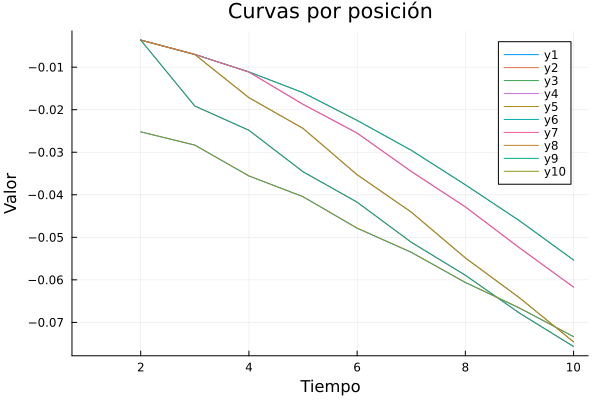

In [19]:
system_of_correlations = []
for t in 1:10
    push!(system_of_correlations, correlation_between_chains(B_t_swap[t]))
end


# data: lista de T listas de N elementos
mat = hcat(system_of_correlations...)  # Convierte a matriz N x T
plot(mat' , legend=:topright, xlabel="Tiempo", ylabel="Valor", title="Curvas por posición")


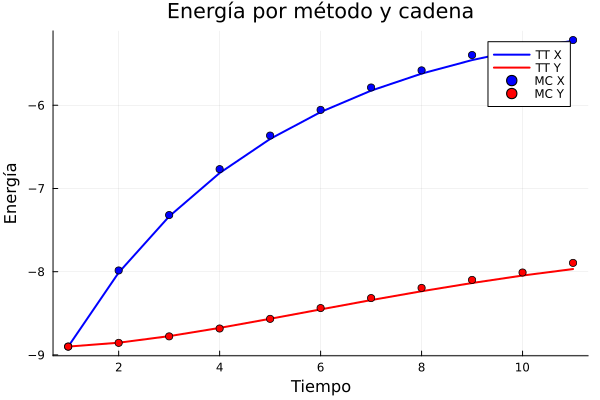

In [20]:
# Gráfica de resultados MonteCarlo vs TT energía por cadena

system_of_observables_swap = system_description_over_time(B_t_swap, params)

energy_mc_x = observables_mc["energy_x"]
energy_mc_y = observables_mc["energy_y"]
energy_tt = system_of_observables_swap.energy_t

T = length(energy_mc_x)
times = 1:T

# Extraer las energías X e Y de TT
energy_tt_x = [e[1] for e in energy_tt]
energy_tt_y = [e[2] for e in energy_tt]

q = plot(title="Energía por método y cadena", xlabel="Tiempo", ylabel="Energía", legend=:topright, grid=true)

# Líneas TT
plot!(q, times, energy_tt_x, color=:blue, linewidth=2, label="TT X")
plot!(q, times, energy_tt_y, color=:red, linewidth=2, label="TT Y")

# Puntos MC
scatter!(q, times, energy_mc_x, color=:blue, marker=:circle, label="MC X")
scatter!(q, times, energy_mc_y, color=:red, marker=:circle, label="MC Y")

display(q)


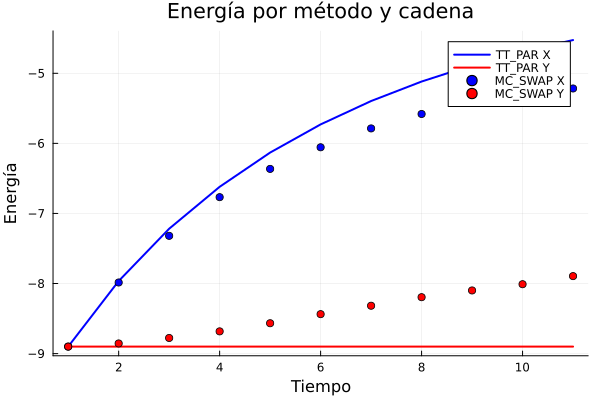

In [21]:
# Gráfica de resultados MonteCarlo vs TT energía por cadena

system_of_observables = system_description_over_time(B_t_parallel_fixed, params)

energy_mc_x = observables_mc["energy_x"]
energy_mc_y = observables_mc["energy_y"]
energy_tt = system_of_observables.energy_t
T = length(energy_mc_x)
times = 1:T

# Extraer las energías X e Y de TT
energy_tt_x = [e[1] for e in energy_tt]
energy_tt_y = [e[2] for e in energy_tt]

q = plot(title="Energía por método y cadena", xlabel="Tiempo", ylabel="Energía", legend=:topright, grid=true)

# Líneas TT
plot!(q, times, energy_tt_x, color=:blue, linewidth=2, label="TT_PAR X")
plot!(q, times, energy_tt_y, color=:red, linewidth=2, label="TT_PAR Y")

# Puntos MC
scatter!(q, times, energy_mc_x, color=:blue, marker=:circle, label="MC_SWAP X")
scatter!(q, times, energy_mc_y, color=:red, marker=:circle, label="MC_SWAP Y")

display(q)

In [22]:
A = parallel_transition_tensor_train(transition_rate, parallel_random_params(10))

TensorTrain{Float64, 4, Array{Float64, 4}, LogFloat64}([[0.8156939322635753 0.0 … 0.0 0.0;;; 0.0 0.3205383367737589 … 0.0 0.0;;; 0.0 0.0 … 0.09772266497867843 0.0;;; 0.0 0.0 … 0.0 0.028034203593200153;;;; 0.14696773617584008 0.0 … 0.0 0.0;;; 0.0 0.6421233316656564 … 0.0 0.0;;; 0.0 0.0 … 0.03776284931094052 0.0;;; 0.0 0.0 … 0.0 0.10745131069641879;;;; 0.03163795910165214 0.0 … 0.0 0.0;;; 0.0 0.012432578431983313 … 0.0 0.0;;; 0.0 0.0 … 0.6235549231905098 0.0;;; 0.0 0.0 … 0.0 0.17888240841650282;;;; 0.005700372458932491 0.0 … 0.0 0.0;;; 0.0 0.024905753128601313 … 0.0 0.0;;; 0.0 0.0 … 0.24095956251987136 0.0;;; 0.0 0.0 … 0.0 0.6856320772938782], [0.7558480235888986 0.0 … 0.0 0.0; 0.637967175660665 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0007040312083968

In [23]:
function double_delta_vector(spin_value_1, spin_value_2 , Q = 2 , σ = x -> 2x-3)
        return [(spin_value_1 == σ((q % Q) + 1)) & (spin_value_2 == σ( (q ÷ Q) +1 ))   ? 1.0 : 0.0 for q in 1:Q*Q]'
    end

for j in 1:2
    for i in 1:2
        print(double_delta_vector(2*i-3, 2*j-3))
    end
end

adjoint([0.0, 0.0, 0.0, 0.0])adjoint([1.0, 0.0, 0.0, 0.0])adjoint([0.0, 1.0, 0.0, 0.0])adjoint([0.0, 0.0, 1.0, 0.0])

In [24]:
B= B_t_plus_fixed[18]

TensorTrain{Float64, 3, Array{Float64, 3}, LogFloat64}([[0.11694018908820614 0.29420727094083204 -0.16869402080558493 0.4244142962568256;;; 0.16869447198817075 0.42441411692225833 0.11694080913409761 -0.2942070244877976;;; 0.294206973645054 -0.11693957413462014 -0.42441450234413736 -0.1686944470958647;;; 0.4244143230104687 -0.16869489827801615 0.2942067271913657 0.11694019418082764], [0.38251174431119245 0.17313612683655397 … -0.25279716396882135 -0.1504089142873709; 0.00208458586070258 0.23101960105397726 … -0.001335019962917959 -0.0007946881128988149; -0.0015094904490105603 -0.0006950639535872648 … 0.19444188474182522 -0.3280153091150482; 8.226117281605843e-6 0.0009121430539728684 … -0.0010586560264941162 0.0017884412725449165;;; 0.2941600474045266 0.1330771608568562 … 0.32873787348647493 0.19559348945403449; 0.0016030817069228262 0.17765735790341328 … 0.0018114636229583422 0.001072094187827101; 0.0019628773767528048 0.0008788712706639154 … 0.15189513292271548 -0.25372846069477845; -

In [25]:
function max_tt(B)
    return 10^10
end

identity_tensor_train(N, qs) = [ones(1,1,qs...) for _ in 1:N] |> TensorTrain
identity_tensor_train(N,qs...) = identity_tensor_train(N,qs)
identity_tensor_train(A::AbstractTensorTrain) = identity_tensor_train(length(A), size(A[1])[3:end])


function divide_by_constant!(B, constant)
    B.z *= constant
    return B
end

function multiply_by_constant!(B, constant)
    B.z /= constant
    return B
end

function inverse_tt(B, steps, bond)
    B0 = 1 / max_tt(B)
    
    # Bn = B0 * (2I - B0 * B)
    temp = multiply_by_constant!(deepcopy(B), B0)
    two = multiply_by_constant!(identity_tensor_train(B), 2)
    Bn = multiply_by_constant!( two - temp, B0)
    
    #Bn = Bn - temp
    
    for _ in 1:steps
        # X_{n+1} = X_n * (2I - B * X_n)
        temp1 = B * Bn
        compress!(temp1; svd_trunc=TruncBond(bond))
        Bnn = two - temp1
        
        Bn = Bnn * Bn
        compress!(Bn; svd_trunc=TruncBond(bond))

        normalize_eachmatrix!(Bn)
    end
    
    return Bn
end

inverse_tt (generic function with 1 method)

In [26]:
B = rand_tt(10, 7, 2)
B1 = inverse_tt(B, 100, 9)
#B1.z = 1

TensorTrain{Float64, 3, Array{Float64, 3}, LogFloat64}([[1.0 -0.6650830716414281;;; 0.6650830716414281 1.0], [0.7027286565706076 0.6478961048997494 0.3920219000312505 -0.23219595394417022; 0.003995069201870308 -0.34715328606474066 -0.025723414207240364 -1.0;;; 0.7920460598116443 -0.5753211300012222 -0.343560197596246 0.2117264409103102; -0.0035457630128563136 -0.49991388182991564 0.9213124253623154 0.1498332801261538], [0.8375993169901027 0.6320493120315861 … -0.00012667931516425552 -0.009585568936484485; 0.003356432194527569 -0.05600065112260926 … 0.5995544605721802 0.10833031993743777; 3.381930087335773e-5 0.3514717081836034 … 0.1558622006262544 -0.08388141904629973; -9.674711387079776e-7 0.005535981857647503 … 0.8032695138421788 0.3241174225935079;;; 0.6737790698060464 -0.7847431782699755 … -0.004250893795751868 0.013665391837545816; -0.004169785332554471 0.11611542474038133 … -0.2266290583994802 0.36670312159224616; -4.6618619497771535e-5 0.0063141036541495745 … -0.1858386221897304

In [27]:
@show B.z B1.z;

B.z = +exp(0.0)
B1.z = +exp(8.012074583514085)

B1.z = +exp(8.012074583514085)


In [28]:
x = rand(1:2, length(B))
@show evaluate(B,x) 1/evaluate(B1,x)

evaluate(B, x) = 12580.021682885617
1 / evaluate(B1, x) = 12580.02168288573

1 / evaluate(B1, x) = 12580.02168288573


12580.02168288573

In [29]:
X = [rand(1:2, 10) for _ in 1:1000]

1000-element Vector{Vector{Int64}}:
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
 [1, 2, 2, 1, 1, 2, 1, 1, 1, 1]
 [1, 2, 2, 1, 2, 1, 1, 1, 1, 1]
 [1, 1, 1, 1, 1, 2, 2, 2, 1, 1]
 [1, 1, 2, 1, 2, 2, 2, 2, 2, 1]
 [2, 1, 1, 1, 1, 2, 1, 2, 2, 1]
 [1, 1, 2, 1, 1, 2, 2, 2, 2, 1]
 [1, 1, 1, 2, 1, 2, 1, 1, 2, 1]
 [1, 1, 1, 1, 1, 1, 2, 2, 2, 1]
 [2, 1, 1, 1, 2, 2, 1, 2, 1, 1]
 ⋮
 [2, 2, 2, 2, 2, 2, 2, 1, 1, 2]
 [2, 2, 2, 2, 2, 1, 2, 1, 1, 1]
 [2, 2, 1, 1, 2, 1, 2, 2, 1, 2]
 [2, 2, 1, 1, 2, 1, 1, 1, 1, 2]
 [1, 2, 1, 1, 2, 1, 1, 2, 1, 1]
 [1, 1, 2, 1, 1, 2, 2, 2, 1, 2]
 [1, 2, 1, 2, 1, 2, 2, 2, 2, 1]
 [1, 2, 1, 2, 1, 2, 1, 2, 2, 2]
 [2, 2, 1, 1, 2, 1, 2, 1, 2, 1]

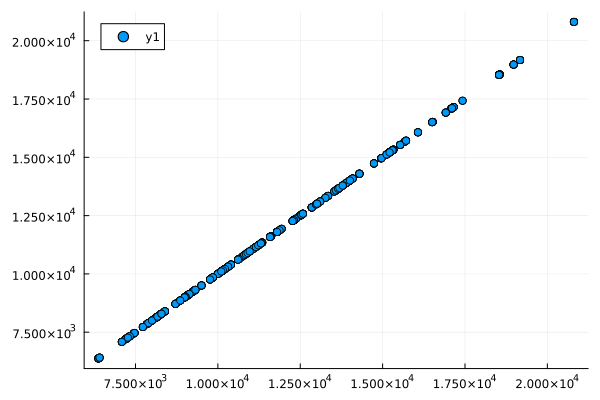

In [30]:
scatter([evaluate(B,x) for x in X], [1/evaluate(B1,x) for x in X])